# Project: Investigate a Dataset - tmdb-movies.csv

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### Dataset Description 

> This dataset contains over 10,000 movies from the Tmdb movie platform, It contains columns like: `cast`,  `budget`, `revenue`, `runtime` and so many other columns that will help in analysing the data


### Question(s) for Analysis
##### Q1 Does higher budget equate higher revenue?
##### Q2: Will movies generate bigger revenues in the future?

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
% matplotlib inline

movies = pd.read_csv('Database_TMDb_movie_data/tmdb-movies.csv')


In [2]:
# Upgrade pandas to use dataframe.explode() function. 
#!pip install --upgrade pandas==0.25.0


<a id='wrangling'></a>
## Data Wrangling/cleaning
We have to wrangle the data to pinpoint the necessary cleaning needed.
cleanings could involve of some these:
<ul>
    <li>removing duplicate values</li>
    <li>Changing `release_date` to date-time</li>
    <li>removing rows where `budget_adj` and `revenue_adj`  = 0</li>
    <li>removing columns that are not useful in the analysis</li>


</ul>



In [3]:
# reading the first 5 rows of the dataset
movies.head(3)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08


In [4]:
movies.shape

(10866, 21)

In [5]:
#checking for duplicate rows
movies.duplicated().sum()

1

In [6]:
#removing duplicates
movies.drop_duplicates(inplace = True)
movies.duplicated().sum()

0

some columns are not important for our analysis, the next step is to remove those columns.

In [7]:
# Deleting columns that are not important for my analysis
movies.drop(['id','imdb_id','overview','tagline', 'keywords','homepage', 'production_companies'],axis = 1, inplace = True)

In [8]:
#checking for null values using the .info() function
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 14 columns):
popularity        10865 non-null float64
budget            10865 non-null int64
revenue           10865 non-null int64
original_title    10865 non-null object
cast              10789 non-null object
director          10821 non-null object
runtime           10865 non-null int64
genres            10842 non-null object
release_date      10865 non-null object
vote_count        10865 non-null int64
vote_average      10865 non-null float64
release_year      10865 non-null int64
budget_adj        10865 non-null float64
revenue_adj       10865 non-null float64
dtypes: float64(4), int64(5), object(5)
memory usage: 1.2+ MB


We have to further drop null values from some columns that still have nulls 

In [9]:
movies.dropna(subset = ['genres', 'director','cast'], inplace = True)
movies.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10731 entries, 0 to 10865
Data columns (total 14 columns):
popularity        10731 non-null float64
budget            10731 non-null int64
revenue           10731 non-null int64
original_title    10731 non-null object
cast              10731 non-null object
director          10731 non-null object
runtime           10731 non-null int64
genres            10731 non-null object
release_date      10731 non-null object
vote_count        10731 non-null int64
vote_average      10731 non-null float64
release_year      10731 non-null int64
budget_adj        10731 non-null float64
revenue_adj       10731 non-null float64
dtypes: float64(4), int64(5), object(5)
memory usage: 1.2+ MB


In [10]:
#changing release_date from object to date-time
movies.release_date = pd.to_datetime(movies['release_date'])

Before I remove rows with 0 values in `budget_adj` and `revenue_adj` I need to use a copy of the movies dataset as this operation will drastically reduce the dataset.

In [11]:
movies[movies['revenue_adj'] != 0]

,popularity,budget,revenue,original_title,cast,director,runtime,genres,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09
1,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,2015-05-13,6185,7.1,2015,1.379999e+08,3.481613e+08
2,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure|Science Fiction|Thriller,2015-03-18,2480,6.3,2015,1.012000e+08,2.716190e+08
3,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,2015-12-15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action|Crime|Thriller,2015-04-01,2947,7.3,2015,1.747999e+08,1.385749e+09
5,9.110700,135000000,532950503,The Revenant,Leonardo DiCaprio|Tom Hardy|Will Poulter|Domhn...,Alejandro GonzÃ¡lez IÃ±Ã¡rritu,156,Western|Drama|Adventure|Thriller,2015-12-25,3929,7.2,2015,1.241999e+08,4.903142e+08
6,8.654359,155000000,440603537,Terminator Genisys,Arnold Schwarzenegger|Jason Clarke|Emilia Clar...,Alan Taylor,125,Science Fiction|Action|Thriller|Adventure,2015-06-23,2598,5.8,2015,1.425999e+08,4.053551e+08
7,7.667400,108000000,595380321,The Martian,Matt Damon|Jessica Chastain|Kristen Wiig|Jeff ...,Ridley Scott,141,Drama|Adventure|Science Fiction,2015-09-30,4572,7.6,2015,9.935996e+07,5.477497e+08
8,7.404165,74000000,1156730962,Minions,Sandra Bullock|Jon Hamm|Michael Keaton|Allison...,Kyle Balda|Pierre Coffin,91,Family|Animation|Adventure|Comedy,2015-06-17,2893,6.5,2015,6.807997e+07,1.064192e+09
9,6.326804,175000000,853708609,Inside Out,Amy Poehler|Phyllis Smith|Richard Kind|Bill Ha...,Pete Docter,94,Comedy|Animation|Family,2015-06-09,3935,8.0,2015,1.609999e+08,7.854116e+08


In [12]:
mv_copy = movies.copy()
#removing the rows with 0 values 
mv_copy = mv_copy[(mv_copy['revenue_adj'] > 0) & (mv_copy['budget_adj'] > 0)]
mv_copy.head()

,popularity,budget,revenue,original_title,cast,director,runtime,genres,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09
1,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,2015-05-13,6185,7.1,2015,1.379999e+08,3.481613e+08
2,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure|Science Fiction|Thriller,2015-03-18,2480,6.3,2015,1.012000e+08,2.716190e+08
3,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,2015-12-15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action|Crime|Thriller,2015-04-01,2947,7.3,2015,1.747999e+08,1.385749e+09


In [13]:
sum(mv_copy['revenue_adj'] == 0)

0

In [14]:
#checking for 0 values
mv_copy[mv_copy['budget_adj'] == 0]

,popularity,budget,revenue,original_title,cast,director,runtime,genres,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj


In [15]:
mv_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3849 entries, 0 to 10848
Data columns (total 14 columns):
popularity        3849 non-null float64
budget            3849 non-null int64
revenue           3849 non-null int64
original_title    3849 non-null object
cast              3849 non-null object
director          3849 non-null object
runtime           3849 non-null int64
genres            3849 non-null object
release_date      3849 non-null datetime64[ns]
vote_count        3849 non-null int64
vote_average      3849 non-null float64
release_year      3849 non-null int64
budget_adj        3849 non-null float64
revenue_adj       3849 non-null float64
dtypes: datetime64[ns](1), float64(4), int64(5), object(4)
memory usage: 451.1+ KB


In [16]:
mv_copy.dropna(subset = ['revenue_adj', 'budget_adj'], inplace = True)

In [17]:
#checking the size of mv_copy dataset
mv_copy.shape

(3849, 14)

<a id='eda'></a>
## Exploratory Data Analysis


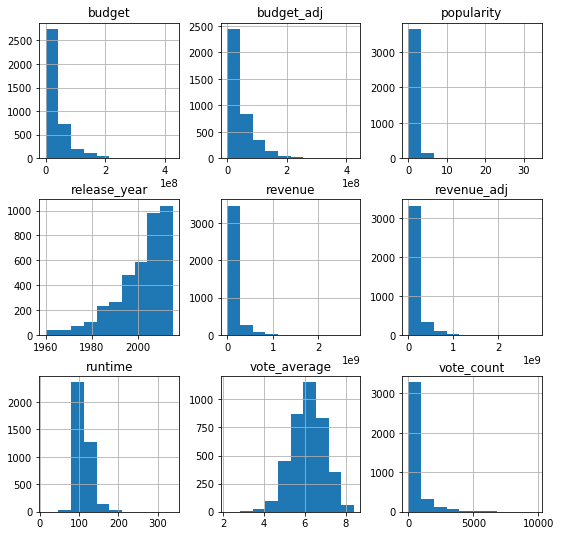

In [18]:
#plotting a histogram for all possible columns
mv_copy.hist(figsize = (9,9));

### Trying to plot a histogram of top 10 directors with the highest number of movies

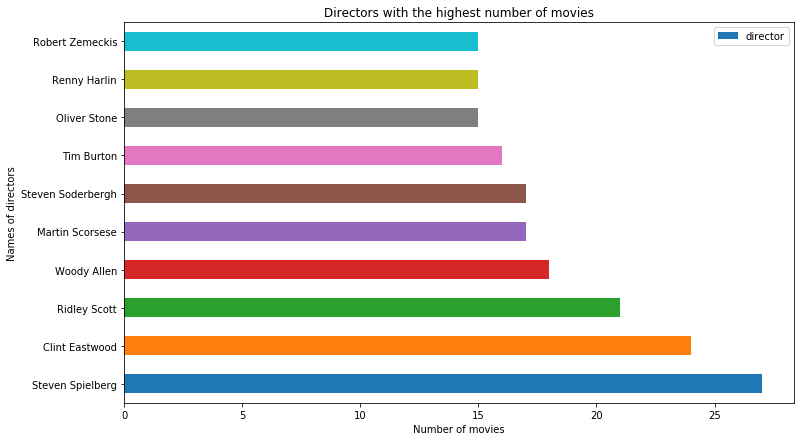

In [19]:
top_dir = mv_copy.director.value_counts().sort_values(ascending = False)
top_10_dir = top_dir[:10]
top_10_dir.plot(kind = 'barh', figsize = (12,7),)
plt.xlabel('Number of movies')
plt.ylabel("Names of directors")
plt.title('Directors with the highest number of movies')
plt.legend();

### Research Question 1: Which Directors generated the highest total revenue?

I used `groupby` to sort out directors according to total revenue and sorted them in descending order of revenue

In [20]:
#grouping top 10 directors according to revenue
best_dir = mv_copy.groupby('director')['revenue_adj'].sum().sort_values(ascending = False)
best_dir10 = best_dir[:10]
best_dir_rest = best_dir[10:]
best_dir10

director
Steven Spielberg     1.520245e+10
James Cameron        7.327221e+09
Peter Jackson        7.019848e+09
George Lucas         6.313919e+09
Robert Zemeckis      5.655648e+09
Michael Bay          5.460672e+09
Chris Columbus       4.893486e+09
Tim Burton           4.529285e+09
David Yates          4.177455e+09
Christopher Nolan    4.164262e+09
Name: revenue_adj, dtype: float64

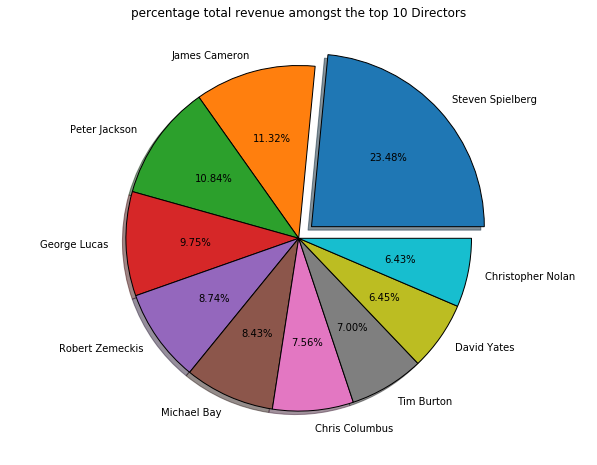

In [21]:
#piechart of top 5 directors by total revenue generated
fig = plt.figure(figsize = (8,6))
ax = fig.add_axes([0,0,1,1])
ax.axis('equal')
directors = ['Steven Spielberg ', 'James Cameron', 'Peter Jackson  ', 'George Lucas', 'Robert Zemeckis','Michael Bay', 'Chris Columbus ', 'Tim Burton','David Yates', 'Christopher Nolan']
exp = [0.1,0,0,0,0,0,0,0,0,0]
revenue = best_dir10
ax.pie(revenue, labels = directors,autopct='%1.2f%%', explode = exp, wedgeprops = {'edgecolor' : 'black'}, shadow = True)
plt.title("percentage total revenue amongst the top 10 Directors")
plt.show()

### Research Question 2: What percentage of the total revenue was generated from top to directors?

In [22]:
best_dir10_sum = best_dir10.sum()
best_dir_rest_sum = best_dir_rest.sum()
#making sure adding first 10 and the rest == total bet_dir series
assert best_dir10_sum + best_dir_rest_sum == best_dir.sum()

# getting the value of both in a list
best_dir_both = np.array([best_dir10_sum,best_dir_rest_sum])
best_dir_both


array([  6.47442433e+10,   4.63459102e+11])

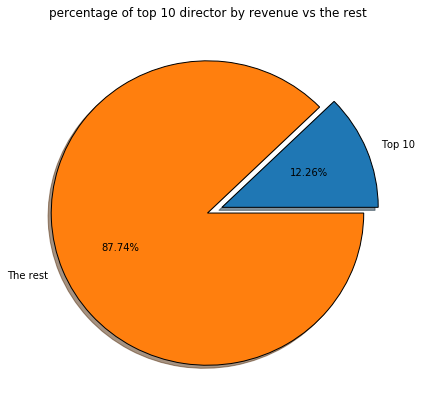

In [23]:
#finding what percentage revenue of the entire dataset does the top 10 directors produce
fig = plt.figure(figsize = (7,7))
label = ['Top 10', 'The rest']
exp = [0.1,0]
plt.pie(best_dir_both, labels = label, wedgeprops = {'edgecolor': 'black'}, explode = exp, shadow = True, autopct='%1.2f%%')
plt.title('percentage of top 10 director by revenue vs the rest');

### Research Question 3: Does higher budget result in higher revenue?

We shall first plot budget against revenue to see if we can get a clear relationship

In [24]:
mv_copy.head()

,popularity,budget,revenue,original_title,cast,director,runtime,genres,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,Colin Trevorrow,124,Action|Adventure|Science Fiction|Thriller,2015-06-09,5562,6.5,2015,1.379999e+08,1.392446e+09
1,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,George Miller,120,Action|Adventure|Science Fiction|Thriller,2015-05-13,6185,7.1,2015,1.379999e+08,3.481613e+08
2,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,Robert Schwentke,119,Adventure|Science Fiction|Thriller,2015-03-18,2480,6.3,2015,1.012000e+08,2.716190e+08
3,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,J.J. Abrams,136,Action|Adventure|Science Fiction|Fantasy,2015-12-15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,James Wan,137,Action|Crime|Thriller,2015-04-01,2947,7.3,2015,1.747999e+08,1.385749e+09


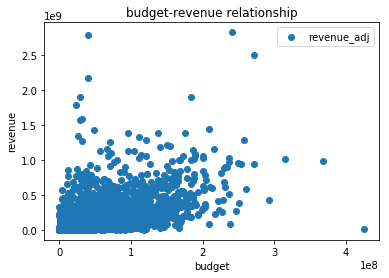

In [25]:
#budget/revenue relationship
plt.scatter(mv_copy['budget_adj'],mv_copy['revenue_adj'])
plt.xlabel('budget')
plt.ylabel('revenue')
plt.title('budget-revenue relationship')
plt.legend();

from the above scatter plot we can see that revenue increases with an increase in budget in as much as there are a few outliers, we can explore more on the data using a bar chat

In [26]:
#using the mean of budget to divide budget into 2: High budget and low budget
b_mean = mv_copy['budget_adj'].mean()
b_mean
high_budget = mv_copy[mv_copy['budget_adj'] >= b_mean]
low_budget = mv_copy.query('{} > budget_adj'.format(b_mean))
high_budg_rev = high_budget['revenue_adj'].mean()
low_budg_rev = low_budget['revenue_adj'].mean()

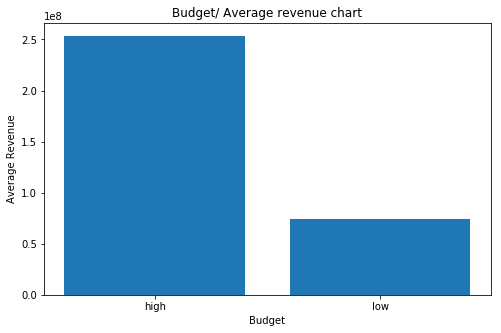

In [27]:
#plotting the barchart
fig = plt.figure(figsize= (8,5))
plt.bar( [1,2],[high_budg_rev,low_budg_rev], tick_label = ['high','low'])
plt.xlabel('Budget')
plt.ylabel('Average Revenue')
plt.title('Budget/ Average revenue chart')
plt.legend();

### Research Question 4: Will movies generate bigger revenues in the future?

To investigate this, we have to see how revenue has peformed over the years. To ensure fairness we shall use the`revenue_adj` column to adjust for inflation.

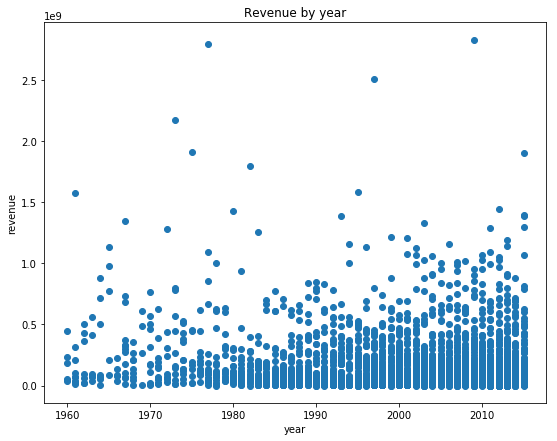

In [28]:
# plotting a scatter plot of year against revenue_adj
plt.figure(figsize = (9,7))
plt.scatter(mv_copy['release_year'], mv_copy['revenue_adj'])
plt.xlabel('year')
plt.ylabel('revenue')
plt.title('Revenue by year');

From the above graph we cannot see any trend in the relationship.
To get a clearer understanding we shall divide the year column into three and plot them against the mean of `revenue_adj`

In [29]:
# calculating the 25%, 50% and 75% of release_year

# 25% of release_year
n = int(25)
n = n/100
a = mv_copy['release_year'].quantile(n)

# 50% (median)
n = int(50)
n = n/100
b = mv_copy['release_year'].quantile(n)

# 75% of release_year
n = int(75)
n = n/100
c = mv_copy['release_year'].quantile(n)
c


2010.0

In [30]:
mv_copy.release_year.describe()

count    3849.000000
mean     2001.258249
std        11.285642
min      1960.000000
25%      1995.000000
50%      2004.000000
75%      2010.000000
max      2015.000000
Name: release_year, dtype: float64

In [31]:
#establishing the 3 groups for release_year
low_yr = mv_copy[mv_copy['release_year']<= a]
mid_yr = mv_copy[(mv_copy['release_year']> a) & (mv_copy['release_year']<= b)]
high_yr = mv_copy[(mv_copy['release_year']> b)]

In [32]:
# we can now subset low_yr, mid_yr, and high_yr with revenue_adj and getting the mean
low_yr_rev = low_yr['revenue_adj'].mean()
mid_yr_rev = mid_yr['revenue_adj'].mean()
high_yr_rev = high_yr['revenue_adj'].mean()
high_yr_rev


123810823.72711354

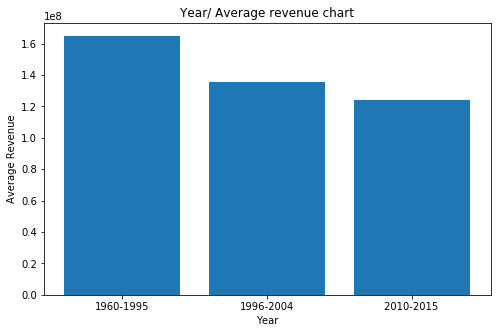

In [33]:
# plot a bar chart 
fig = plt.figure(figsize= (8,5))
label = ['1960-1995', '1996-2004', '2010-2015 ']
plt.bar( [1,2,3],[low_yr_rev, mid_yr_rev, high_yr_rev], tick_label = label)
plt.xlabel('Year')
plt.ylabel('Average Revenue')
plt.title('Year/ Average revenue chart')
plt.legend();

<a id='conclusions'></a>
## Conclusions
the 1st and 2nd show that 10 people generated about 12% of the revenue between 1960 and 2015, which a huge percentage for such a small number of people. Amongst the top 10 revenue generators, **Steven Spielberg** represents a whooping __23.5%__, making him the top revenue generator by far.

In the 3rd analysis the bar chart made it clear that higher budget almost always result in higher revenue, therefore producers who want to make more money should naturally increase their budgets.

The result of the 4th analysis is quite surprising because when the revenue is adjusted for inflation, revenue continue to plummet as the years pass by.

As revenues have continue to go down every year one can say with all certainty that in other to improve revenue we have to do they following:

- pick a director from the Top ten (especially **Steven Spielberg**) directors above, it is not by chance that they represent over 12% of revenues generated in 55 years and after 3849 movies

- Increase the budget even more as we have seen a very big increase in revenue when budget is increased.

With the combination of  these two approaches and also other approaches not covered in this analysis like runtime, cast and genre, we can turn around this dwindling annual revenue.


#### limitation:
After cleaning my data, it reduced from 10731 rows to 3849, this means that I lost close to 70% of my data during cleaning.
Most of this was lost when i tried to remove zero values from `revenue_adj` and `budget_adj` columns. These loses will hugely hamper the accuracy of my analysis.

#### References: 
- it is important to let you know that piechart features like `autopct`, `edgecolor`, `explode` were gotten from                       [this](https://www.youtube.com/watch?v=MPiz50TsyF0) youtube channel
- I also got some features of barchart from [stackoverflow](https://stackoverflow.com/questions/32956199/bar-chart-with-matplotlib)


In [34]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0